# <span style='color: lightcoral;'> 몬테카를로 실험 </span>

문제를 풀기 위해, (그 문제가 결정론적인 원리라고 하더라도) 컴퓨터을 이용한 반복적인 랜덤 샘플링에 의존하여 결과를 얻는 계산 알고리즘을몬테카를로 실험(Monte Carlo simulation)이라고 합니다. 이 강의에서는 몬테카를로 실험을 이용하여 함수의 적분값을 구하고, 최솟값을 구하는 방법에 대해 알아봅니다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import comb

## <span style='color:blue'> 0.지난 시간에 작성한 확률분포 관련 함수들 불러 들이기

우선 지난 시간에 작성한 확률분포 관련 함수들을 이용하기 위해 읽어 들이겠습니다. 사용하기 편하게 함수의 정의들을 `random_generator.py`에 저장해 두었으므로, 이 파일을 `import`를 이용하여 읽어 들이고 사용하는 방법부터 확인하죠. 
    
    파일에 정의되어 있는 함수들의 이름은 아래와 같습니다. 

- 균등분포 관련 함수들
>- `uniform_generator(a, b, num_samples=100, rand_seed=42)`
>- `estimate_uniform_params(sample)`
>- `pdf_uniform(x, a, b)`
    
- 지수분포 관련 함수들
>- `inverse_cdf_exponential(y,lamb)`
>- `exponential_generator(lamb, num_samples)`

- 정규분포 관련 함수들
>- `inverse_cdf_gaussian(y, mu, sigma)`
>- `gaussian_generator(mu, sigma, num_samples)`
>- `estimate_gaussian_params(sample)`
>- `pdf_gaussian(x, mu, sigma)`

- 이항분포 관련 함수들 
>- `cdf_binomial(x, n, p)`
>- `inverse_cdf_binomial(y, n, p)`
>- `binomial_generator(n, p, num_samples)`
>- `estimate_binomial_params(sample)`
>- `pdf_binomial(x, n, p)`

In [2]:
# 지난 시간에 만든 균등분포, 지수분포, 정규분포, 이항분포 관련 함수들 

import random_generator as rg

In [3]:
# 사용 예 
rg.binomial_generator(20, 0.5, 10)

array([ 9,  7, 11, 10, 14,  9,  9, 11, 12, 13])

## <span style='color:blue'> 1.간략한 이론적 배경

### <span style='color:blue'> 1.1. 큰 수의 법칙 (Law of Lage Numers) </span>

- $X_1,\cdots,X_n$이 서로 독립이고 동일한 확률분포(평균: $\mu$, 분산: $\sigma^2$)를 따르는 iid(Independently and identically distributed) 확률변수라 할 때,  
    
>- 확률변수 $\overline {X}_n=\dfrac{X_1+\cdots+X_n}n$에 대해 다음이 성립
    $$\rm{E}(\overline {X}_n)=\mu, \ \rm{Var}(\overline {X}_n)=\dfrac{\sigma^2}n$$ 
    
>- 이때, $\lim_{n\to \infty} \rm{Var}(\overline{X}_n)=0$이 성립. 즉, $n$이 클수록 확률변수 $\overline{X}_n$는 $\mu$ 근처에 집중된 분포가 된다. (이를 $\overline{X}_n$이 $L_2$ 노름(norm)에 대해 $\mu$로 수렴한다고 말한다.)
    
- 실제로, iid $X_1,\cdots,X_n$의 분산에 대한 조건 없이 $\rm{E}(X_i)=\mu$가 유한한 값이라는 조건만 있으면 다음과 같은 큰 수의 법칙이 성립한다.    
    * 임의의 양수 $\epsilon$에 대해 $\lim_{n\to \infty}P(|\overline{X}_n-\mu|)=0$
    
### <span style='color:blue'> 1.2. 중심극한정리  </span>

- $X_1,\cdots,X_n$이 동일한 분포(평균: $\mu$, 분산: $\sigma^2$)를 따르는 iid이면, 충분히 큰 $n$에 대해 확률변수 $\overline{X}_n=\dfrac{X_1+\cdots+X_n}n$은 근사적으로 정규분포 $N\left(\mu, \bigl(\sigma/\sqrt n\bigr)^2\right)$을 따른다. 

- 좀 더 엄밀하게, $\Phi$를 표준정규분포의 누적분포함수(cdf)라 할 때, $\lim_{n\to \infty}P\left( \dfrac{\overline{X_n}-\mu}{\sigma/\sqrt n}\le x\right)=\Phi(x)$

### <span style='color:blue'> 1.3. 큰 수의 법칙과 중심극한정리를 실험적으로 확인 </span>

- 확률변수 $X_1,\cdots,X_n$이 모수가 $\lambda$인 지수분포 $\text{Exp}(\lambda)$를 따르는 iid라고 할 때, $\overline{X}_n$에 대해 큰 수의 법칙과 중심극한정리가 성립하는지 실험적으로 살펴보자. 

>- $\lambda$가 양수일 때, 평균이 $1/\lambda$이고 분산이 $1/\lambda^2$인 지수분포 $\text{Exp}(\lambda)$에 대한 확률밀도함수 $f$는 다음과 같다.

$$f(x)=\lambda e^{-\lambda x} \ (x\ge 0)$$

In [4]:
# 지수분포에 대한 큰 수의 법칙, 중심극한정리 실험

# n=num_samples일 때, 모수가 lamb인 지수분포의 표본평균 X_n의 샘플 생성하는 함수
def exponential_sample_mean(lamb, num_samples):
    samples = rg.exponential_generator(lamb, num_samples)
    return samples.mean()

# n=num_samples일 때, 모수가 lamb인 지수분포의 표본평균 X_n의 샘플을 num_simulations 개만큼 생성하여 
# 그 리스트 samples와 samples의 평균, 표준편차를 반환하는 함수
def exponential_simulator(lamb, num_samples, num_simulations):
    sample_means = np.zeros(num_simulations)
    for i in range(num_simulations):
        sample_means[i] = exponential_sample_mean(lamb, num_samples)
        
    return sample_means, sample_means.mean(), sample_means.std()

- $n=300$일 때, 지수분포 $\text{Exp}(0.5)$에 대한 표본평균 $\overline{X}_{30}$의 샘플을 10_000개 생성하고, 평균, 표준편차, 분포를 간단한 코드로 확인해 봅시다.  

In [5]:
samples, smean, sstd = exponential_simulator(0.5, 300, 20_000)

In [6]:
# 이론적 평균과 시뮬레이션 결과 비교 
2-smean

-0.0024488088712790734

In [7]:
# 이론적 표준편차와 시뮬레이션 결과 비교 
2/np.sqrt(300) - sstd

-0.0014861875862177687

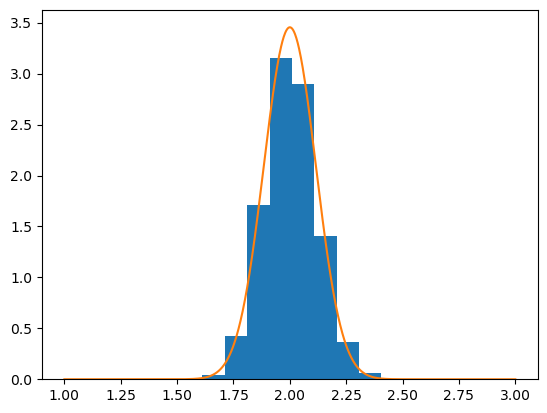

In [8]:
# 근사적으로 얻은 정규분포의 PDF와 생성한 샘플의 히스토그램 비교 

xlist = np.linspace(1,3,1000)
ylist = rg.pdf_gaussian(xlist, 2, 2/np.sqrt(300))

fig, ax = plt.subplots(sharex=True)
ax.hist(samples, density=True)
ax.plot(xlist,ylist)

## <span style='color:blue'> 2.몬테카를로 실험 </span>

### <span style='color:blue'> 2.1. 몬테카를로 실험을 이용한 적분의 근삿값 계산 </span>

- 주어진 적분이 확률밀도함수 $f(x)$에 대해 $\displaystyle{\int_{-\infty}^{\infty} g(x)f(x)dx}$ 꼴일 때, 주어진 적분은 기댓값 $\rm{E}(g(X))$으로 생각할 수 있습니다. 

- 따라서, 이 기댓값은 큰 수의 법칙에 따라 확률밀도함수가 $f$인 분포를 따르는 iid $X_i,\cdots,X_n$에 대해  
$$\overline{Y}_n= \dfrac{g(X_1)+g(X_2)+\cdots+g(X_n)}n$$
를 이용하여 근사적으로 구할 수 있습니다.  

> 즉, 주어진 분포를 따르는 랜덤한 샘플을 $n$개(충분히 많이, 예를 들어 $n=10^5$) 생성하고, 표본평균 $\overline{Y}_n$의 값을 구하면 적분값의 근삿값을 구할 수 있다는 뜻입니다.     

- 이때, 중심극한정리에 의해 적분값에 대한 신뢰도 $(1-\alpha)$인 신뢰구간을 근사적으로 다음과 같이 구할 수 있습니다. 
    $$\left(\overline{Y}_n-z_{1-\alpha/2} \dfrac S{\sqrt{n}}, \overline{Y}_n+z_{1-\alpha/2} \dfrac S{\sqrt{n}}\right)$$
    (단, $S$는 표본표준편차)
    $$ $$
    
- 이 방법으로 적분의 근삿값을 구할 때 문제점은 무엇일까요?

### <span style='color:blue'> 2.1.1. 적분의 근삿값 계산 예제 1: 표준정규분포에 대한 확률 계산 </span> 

- 표준정규분포 $\text{N}(0,1^2)$을 따르는 확률변수 $X$에 대하여, 확률 $\mathbf P(a\le X\le b)$을 구하고 싶다고 하죠.이 적분을 직접할 수 없으므로 몬테카를로 실험을 통해 근삿값을 구해보도록 하겠습니다. 

- 우선 주어진 표준정규분포의 확률밀도함수는 다음과 같습니다. 
$$ $$
$$f(x)=\dfrac{1}{\sqrt{2\pi}}e^{-\frac 1 2 x^2} $$

  이제, 닫힌구간 $\mathcal I=[a,b]$에서는 $1$이고, 나머지 실수에 대해서는 $0$을 함숫값으로 갖는 함수를 $1_{\mathcal I}$라 하면, 구하려는 확률을 다음과 같이 쓸 수 있습니다.  
$$ $$  
$$\displaystyle{\mathbf P(a\le X\le b)=\int_a^b f(x)\,dx=\int_{-\infty}^{\infty}f(x)1_{\mathcal I}(x)\,dx}, $$  

- 즉, 구하려는 적분값은 표준정규분포를 따르는 확률변수 $X$에 대해 
$1_{\mathcal I}$의 기댓값 $\text{E}(1_{\mathcal I}(X))$을 구하는 것입니다. 

- 이제, 앞서 설명한 방법으로 몬테카를로 실험을 통해 원하는 확률의 근삿값을 구해 보죠.

 >-  $-\infty$와 $\infty$를 사용하려면  `-np.inf`, `np.inf`를 쓰면 됩니다. 
 
 >- 함수의 구현에 조건문이 사용되는 경우, 넘파이 배열을 입력으로 전달하면 문제가 생기는 것을 배웠었죠? 정의한 함수 `g`에 대해 `g_vec = np.vectorize(g)`처럼 `g_vec`을 만들어서 사용하던지, 아니면 아래 코드에서처럼 처음부터 `np.where`을 이용하여 함수 `g`를 구현해야 합니다. 

In [9]:
# 표준정규분포에 대한 확률 구하기 
# P(a <= X <= b)인 확률 계산, 무한대는 np.inf

def simulated_prob(a, b, num_simulations, interval=False, verbose=False): # interval이 True이면 신뢰구간도 반환
    
      # [a,b]에서 1, 나머지는 0인 함수를 넘파이 배열 입력에 대해서도 동작하게 구현
    def g(x):  
        return np.where( (x >= a) & (x <= b), 1, 0)
    
      # 표준정규분포를 따르는 랜덤 샘플 num_simulations개 생성
    x = rg.gaussian_generator(0, 1, num_simulations)  
     
      #g(X) 샘플 
    y = g(x)

    #적분 근삿값 및 오차 계산 (신뢰구간 계산)
    z = 1.96 
    mY = np.mean(y)
    sY = np.std(y,ddof=1)
    RE = sY/mY/np.sqrt(num_simulations)
    if interval:
          # verbose가 True일 때만 출력
        if verbose: 
            print('확률 추정값 = {:3.3f}, 95%신뢰구간=({:3.3f},{:3.3f}), n={}'.format(mY, mY*(1-z*RE), mY*(1+z*RE),num_simulations))
        return (mY, mY*(1-z*RE), mY*(1+z*RE))
    else:
        return mY

- 이제 구현한 함수를 이용하여 확률의 근삿값을 구해 봅시다.

- 작성한 함수 사용 

 >- 확률 근삿값만 반환하는 것이 default 설정

 >- 확률 근삿값과 신뢰구간을 모두 반환하고, 그 결과를 `print`로 화면에 출력하려면 `interval=True`, `verbose=True`
 
 >- 확률 근삿값과 신뢰구간을 모두 반환만 하려면 `interval=True`

In [10]:
print(f"P(0<=X<=infinity)={simulated_prob(0, np.inf, 10**5)}")
print(f"P(-infinity<=X<=0)={simulated_prob(-np.inf, 0, 10**5)}")
print(f"P(-1<=X<=1)={simulated_prob(-1, 1, 10**5)}")  # P(|z|<= sigma)
print(f"P(-2<=X<=2)={simulated_prob(-2, 2, 10**5)}")  # P(|z|<= 2*sigma)
print(f"P(-3<=X<=3)={simulated_prob(-3, 3, 10**5)}")  # P(|z|<= 3*sigma)
print(f"P(-0.3<=X<=0.7)={simulated_prob(-0.3, 0.7, 10**5)}")

P(0<=X<=infinity)=0.5026
P(-infinity<=X<=0)=0.5016
P(-1<=X<=1)=0.68253
P(-2<=X<=2)=0.95419
P(-3<=X<=3)=0.99773
P(-0.3<=X<=0.7)=0.37533


- 확률 $\mathbf P(X\le 1.33)$를 표준정규분포표로 구하면 $0.9082$이다.  

- 구현한 함수로 위 확률의 근삿값을 구할 때, 근삿값에 대한 신뢰도 95% 신뢰구간을 확인해보자. 

>- 신뢰도 95% 신뢰구간의 의미는 100개의 신뢰구간 중 대략 95개는 0.95를 포함할 것이라는 의미이다. 

In [11]:
# 이 셀을 여러 다시 실행시키면서 값의 변환를 관찰하세요. 

simulated_prob(-np.inf, 1.33, 10**5, interval=True, verbose=True)

확률 추정값 = 0.908, 95%신뢰구간=(0.906,0.910), n=100000


(0.90802, 0.9062287646450691, 0.909811235354931)

In [12]:
integral_vals = []
conf_starts = np.zeros(100)
conf_ends = np.zeros(100)
for i in range(100):
    val, start, end = simulated_prob(-np.inf, 1.33, 10**5,interval=True) # 확률 근삿값 계산을 위해 100_000번 실험
    integral_vals.append(val)
    conf_starts[i] = start
    conf_ends[i] = end

- $100$번의 계산 중 확률 $0.9082$를 포함하는 신뢰구간의 개수가 $95$개 이상인지 확인 

In [13]:
correct_conf_interval = (conf_starts <= 0.9082) & (conf_ends >= 0.9082)

correct_conf_interval.sum()

94

### <span style='color:blue'> 2.1.2. 적분의 근삿값 계산 예제 2 : 다변수 함수에 대한 다중 적분 </span>

- 다변수 함수의 적분에도 적용할 수 있습니다. 

- 적분값 $\displaystyle{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}
\sqrt{|x_1+x_2+x_3|}e^{-(x_1^2 +x_2^2 + x_3^2)/2}dx_1dx_2dx_3}$의 근삿값을 구해 보겠습니다.  

> 표준정규분포를 따르고 독립인 확률변수 $X_1, X_2,X_3$에 대해 다변량 확률변수 $(X_1,X_2,X_3)$의 결합확률밀도 함수는 $\displaystyle{f(x_1,x_2,x_3)=\dfrac 1{\sqrt{2\pi}^3} e^{-(x_1^2+x_2^2+x_3^2)/2}}$로 주어집니다. 

>따라서 주어진 적분은 $g(x_1,x_2,x_3)=\sqrt{2\pi}^3 \sqrt{|x_1+x_2+x_3|}$이라 할 때, 확률변수 $X_1,X_2,X_3$에 대하여 $\rm{E}(g(X_1,X_2,X_3))$를 구하면 됩니다. 

- 몬테카를로 실험을 통해 적분의 근삿값을 구하는 코드를 작성해보죠.

>- 앞의 예와 같은 아이디어이므로 함수 작성없이 간략하게 근삿값을 한 번만 구하도록 작성해 보겠습니다.  

In [14]:
c = (2*np.pi)**(3/2)

def g(x): # x는 (N,3) shape를 갖는 넘파이 배열
    return c * np.sqrt(np.abs(np.sum(x, axis=1)))  # (N,) shape 반환


N = 10**7

  # (N,3) shape를 갖고 각 성분이 표준정규분포를 따르는 랜덤 샘플이 되도록 넘파이 배열을 만드는 함수 
def gaussian_vec_generator(N):
    temp = rg.gaussian_generator(0, 1, 3*N)
    return temp.reshape((N,3))

x = gaussian_vec_generator(N)  # `x = np.random.randn(N,3)`를 사용해도 됩니다.

#Y를 독립적으로 N개 생성
y = g(x)

#적분 근삿값 및 오차 계산 
z = 1.96 
mY = np.mean(y)
sY = np.std(y)
RE = sY/mY/np.sqrt(N)

print('적분 추정값 = {:3.3f}, 95%신뢰구간=({:3.3f},{:3.3f})'.format(mY, mY*(1-z*RE), mY*(1+z*RE)))

적분 추정값 = 17.041, 95%신뢰구간=(17.037,17.046)


### <span style='color:blue'> 2.2. 몬테카를로 실험을 이용하여 함수의 최솟값에 대한 근삿값 구하기 </span>


- 함수 $f(x)$가 $x=a$에서 최솟값을 가진다면 $x=a$ 근방의 $x$에 대해 $f(x)$는 다른 위치에서보다 작은 함숫값을 가질 것을 기대할 수 있습니다. 
$$ $$

- 즉, 최솟값이 $m=f(a)$라 할 때, 
$$f(x) \le m+\epsilon\,\, (\epsilon>0) \qquad \qquad (1)$$
$$ $$
을 만족하는 $x$들은 $x=a$ 근처에 집중해서 분포한다고 생각할 수 있겠죠.
$$ $$

- 이 아이디어에 착안하면 $f(x)$가 최소가 되는 $x=a$에 대해, 평균이 $a$이고 표준편차 $\sigma$가 아주 작은 정규분포 $\text{N}(a,\sigma^2)$을 따르는 랜덤 샘플 $x$은 식 (1)을 만족시킬 가능성이 아주 높습니다. 즉, 만약 정규분포 $\text{N}(a,\sigma^2)$을 따르는 $n$개의 랜덤 샘플 $x_1,\cdots, x_n$이 주어질 때, 식 (1)을 만족시키는 $x_i$의 개수를 $k$라 하면 $k/n\approx 1$이라는 의미입니다. 

- 따라서 함수가 최소가 되는 $x=a$를 찾는 문제를 다음과 같이 확률적으로 접근할 수 있습니다.  

> (단계 1) 우선, 함수의 정의역을 포함할 수 있도록 충분히 큰 $\sigma_0$과 임의의 평균 $\mu_0$에 대해 정규분포 $\text{N}(\mu_0,\sigma_0)$를 따르는 랜덤 샘플을 $N$개 만큼 생성합니다. 그런 다음 생성된 $N$개의 랜덤 샘플 $x_1, \cdots, x_N$에 대해 함숫값을 계산하고, 이 중 함숫값이 가장 것부터 $n$(대략 $n=0.1N$ 정도)개를 골라 냅니다. 
$$ $$
 -- 이 과정은 함수의 최솟값을 모르는 상황에서 식 (1)을 근사적으로 표현하는 것으로 이해할 수 있습니다. 

> (단계 2) 이제, 골라낸 $n$개의 샘플을 이용해서 이런 샘플을 높은 확률로 만들어내는 정규분포 $\text{N}(\mu_1,\sigma_1^2)$를 역으로 추정합니다. (지난 주제를 공부할 때, 샘플로부터 정규분포의 평균과 표준편차를 최대우도추정법을 이용하여 추정하는 방법을 배웠죠?) 
$$ $$
 -- 이 과정은 $N$개 샘플 중에서 상대적으로 작은 함숫값을 갖은 $n$개의 샘플에 어울리는 정규분포를 찾는 겁니다.)

> (단계 3) 이번엔 정규분포 $\text{N}(\mu_1,\sigma_1^2)$를 따르는 랜덤 샘플을 $N$개 생성하고, (단계 1)에서처럼 함숫값이 작은 순서로 $n$개를 고르고, 이를 이용하여 (단계 2)와 같은 방법으로 정규분포를 추정하여 $\text{N}(\mu_2,\sigma_2^2)$를 구합니다. 
$$ $$
 -- 이때, $\text{N}(\mu_1,\sigma_1^2)$을 따르는 랜덤 샘플 $x$에 대한 함숫값 $f(x)$보다  $\text{N}(\mu_2,\sigma_2^2)$를 따르는 랜덤 샘플 $x$에 대한 함숫값이 더 작아지며, $\sigma_1$보다 $\sigma_2$가 작아지는 것을 기대할 수 있습니다. 
 
> 위와 같은 방법으로 정규분포의 평균 $\mu_k$와 표준편차 $\sigma_k$를 $\mu_{k+1}$와 $\sigma_{k+1}$로 업데이트시킬 때, $\sigma_k$가 충분히 작아지면서 $\mu_k$가 수렴하면 $\mu_k$의 수렴값이 함수가 최소가 되는 $x=a$가 될 겁니다.  
$$ $$
 -- 수렴하는지를 실험으로 판단하는 방법 중 하나는 $|\mu_{k+1}-\mu_k|$가 정해진 기준(예를 들어, $10^{-6}$)보다 작아지는지를 확인하는 겁니다. 


### <span style='color:blue'> 2.2.1  다음 함수의 최솟값을 앞에서 설명한 방법으로 구해보기</span>

$$ f(x)= -e^{-\frac{x^2}{100}} \sin(13x-x^4)^5 \sin(1-3x^2)^2,\ (-2\le x \le 2)$$

- 우선 계산할 때, 넘파이 배열로 주어지는 $N$개의 $x$에 대해 함숫값을 계산하고, 크기가 작은 순서로 배열하는 것이 쉽도록 함수를 정의하겠습니다. (정의역 밖의 함숫값을 `np.inf`를 써서 $\infty$로 설정)

>- 아래 코드에서 사용하는 `np.argwhere(a)`는 넘파이 배열 `a`를 입력으로 받아 `0`이 아닌 `a`의 요소의 index를 `(N, a.ndim)`shape의 배열 형태로 반환하는 함수입니다. 

In [15]:
# np.argwhere 확인부터 

np.argwhere(np.array([1,0,-1,0]))

array([[0],
       [2]], dtype=int64)

In [16]:
np.argwhere(np.array([[1,0],[-1,0]]))

array([[0, 0],
       [1, 0]], dtype=int64)

In [17]:
# 함수 구현   
    
  # 입력 인자 x는 shape가 (N,1)인 2차원 넘파이 배열 
def f(x):
    y = -np.exp(x**2/100) * np.sin(13*x-x**4)**5 * np.sin(1-3*x**2)**2 
    idx = np.vstack((np.argwhere(x<-2), np.argwhere(x>2)))
    y[idx] = np.inf #float('inf')
    return y

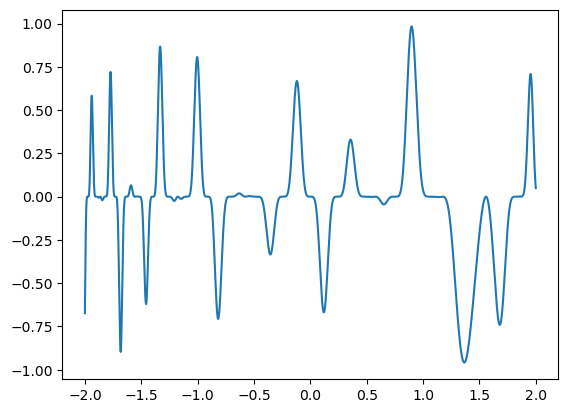

In [18]:
# 함수 그래프 파악

xlist = np.linspace(-2,2,10**4)
ylist = f(xlist)
plt.plot(xlist,ylist)

- 그래프를 보면 알 수 있듯이, 함수 $f(x)$는 극솟값을 많이 갖는 함수입니다. 

- 앞서 설명한 아이디어를 코드로 작성하고 최솟값을 잘 찾는지 확인해보죠. 

> 평균이 수렴하는지 판단하는 기준값 `eps`는 $10^{-6}$, 처음에 임의로 정한 평균과 표준편차는 각각  $\mu_0=0$, $\sigma_0=3$으로 두고, $N=100$, $n$=10부터 실험해 보겠습니다. 

> 결과가 좋지 않으면 $N$, $n$값을 좀 더 크게 잡기로 하죠. 

In [19]:
eps = 10**-6
mu, sigma = 0,3
N,n = 100, 10

while sigma > eps:
      # 지난 시간에 작성한 `rg.guassian_generator`로 `N`개 생성한 후, 2차원 배열이 되게 `reshape`메서드 이용 
      # `sigma * np.random.randn(N,1) + mu * np.array(np.ones((N,1)))`처럼 `np.random.randn`함수를 쓸 수도 있음
    X = rg.gaussian_generator(mu, sigma, N).reshape((N,1))
      
      # 함숫값이 작은 순서로 sorting 하는 것을 쉽게 하기 위해 `X`,`f(X)`를 붙여서 처리
    tuple_xf = np.hstack((X,f(X)))
    sort_xf = tuple_xf[tuple_xf[:,1].argsort(),]
    
      # n개 추려내기
    elite_x = sort_xf[0:n, :-1]
    
      # 추려낸 n개로 정규분포 모수 추정
    mu = np.mean(elite_x,axis=0)
    sigma = np.std(elite_x,axis=0)
    print('finding... : f(mu)={}, mu: {}, sigma: {}\n'.format(f(mu), mu, sigma))

print(f"f(x)의 최솟값은 x={mu[0]}일 때, {f(mu)[0]}으로 추정됩니다.")

finding... : f(mu)=[0.25853595], mu: [0.38013406], sigma: [1.43672985]

finding... : f(mu)=[0.00013018], mu: [-0.22694006], sigma: [0.98031825]

finding... : f(mu)=[-0.01041804], mu: [-0.27834573], sigma: [0.78705348]

finding... : f(mu)=[0.00810696], mu: [0.27727384], sigma: [0.74877883]

finding... : f(mu)=[-0.00454431], mu: [0.70801909], sigma: [0.91177568]

finding... : f(mu)=[-0.63477618], mu: [1.44016065], sigma: [0.11589429]

finding... : f(mu)=[-0.95732925], mu: [1.36853826], sigma: [0.00693856]

finding... : f(mu)=[-0.95794381], mu: [1.36553602], sigma: [0.0003471]

finding... : f(mu)=[-0.95794557], mu: [1.36566698], sigma: [4.18569787e-05]

finding... : f(mu)=[-0.9579456], mu: [1.36568865], sigma: [3.07169928e-06]

finding... : f(mu)=[-0.9579456], mu: [1.36568922], sigma: [1.69875815e-07]

f(x)의 최솟값은 x=1.3656892185806166일 때, -0.9579456035361987으로 추정됩니다.
